In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('Question_Year_QNumber_Topic.csv')
print(df.head(10))
print(df.columns)
df = df[['Question','Topic']]
df = df[pd.notnull(df['Question'])]
df.head(10)

                                            Question                 Topic
0  Rehabilitation, not punishment, should be the ...  Crime and Punishment
1  To what extent is it possible to make the puni...  Crime and Punishment
2  How far can an individual be held responsible ...  Crime and Punishment
3  Should crimes that were committed many years a...  Crime and Punishment
4  Too much attention is given to criminals; not ...  Crime and Punishment
5  Should the police have unlimited powers when d...  Crime and Punishment
6  The quality of written language is being destr...  Language and Writing
7  Consider the view that spoken language is more...  Language and Writing
8  Is there any value in preserving minority lang...  Language and Writing
9   Are certain types of writing superior to others?  Language and Writing
Index(['Question', 'Topic'], dtype='object')


,Question,Topic
0,"Rehabilitation, not punishment, should be the ...",Crime and Punishment
1,To what extent is it possible to make the puni...,Crime and Punishment
2,How far can an individual be held responsible ...,Crime and Punishment
3,Should crimes that were committed many years a...,Crime and Punishment
4,Too much attention is given to criminals; not ...,Crime and Punishment
5,Should the police have unlimited powers when d...,Crime and Punishment
6,The quality of written language is being destr...,Language and Writing
7,Consider the view that spoken language is more...,Language and Writing
8,Is there any value in preserving minority lang...,Language and Writing
9,Are certain types of writing superior to others?,Language and Writing


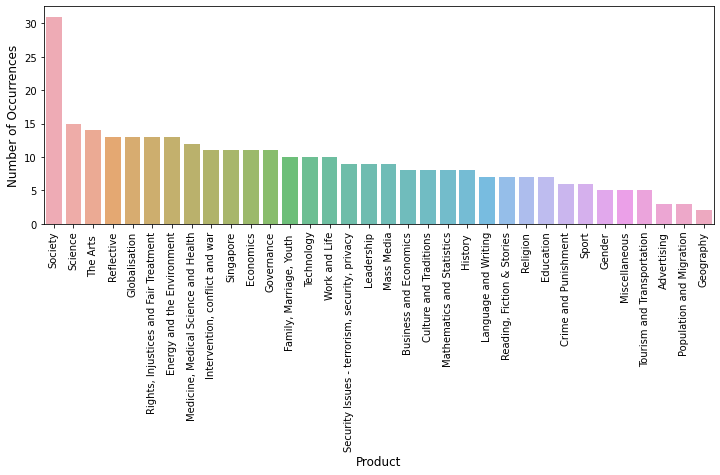

In [10]:
cnt_pro = df['Topic'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [11]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Question'] = df['Question'].apply(cleanText)

In [12]:
print(df.head(10))

                                            Question                 Topic
0  rehabilitation, not punishment, should be the ...  Crime and Punishment
1  to what etent is it possible to make the punis...  Crime and Punishment
2  how far can an individual be held responsible ...  Crime and Punishment
3  should crimes that were committed many years a...  Crime and Punishment
4  too much attention is given to criminals; not ...  Crime and Punishment
5  should the police have unlimited powers when d...  Crime and Punishment
6  the quality of written language is being destr...  Language and Writing
7  consider the view that spoken language is more...  Language and Writing
8  is there any value in preserving minority lang...  Language and Writing
9   are certain types of writing superior to others?  Language and Writing


In [42]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['Question']), tags=[r.Topic]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['Question']), tags=[r.Topic]), axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Beertino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
[x for x in tqdm(train_tagged.values)]

100%|██████████| 224/224 [00:00<00:00, 448032.47it/s]


[TaggedDocument(words=['fashion', 'is', 'as', 'much', 'good', 'thing', 'as', 'bad', 'thing', 'to', 'what', 'extent', 'do', 'you', 'agree'], tags=['Culture and Traditions']),
 TaggedDocument(words=['consider', 'the', 'view', 'that', 'we', 'do', 'not', 'take', 'enough', 'responsibility', 'for', 'our', 'own', 'well-being'], tags=['Medicine, Medical Science and Health']),
 TaggedDocument(words=['can', 'the', 'trade', 'in', 'weapons', 'ever', 'be', 'justified'], tags=['Security Issues - terrorism, security, privacy']),
 TaggedDocument(words=['to', 'what', 'extent', 'do', 'the', 'newspapers', 'and', 'magazines', 'that', 'you', 'read', 'deal', 'with', 'what', 'is', 'trivial', 'rather', 'than', 'what', 'is', 'important'], tags=['Mass Media']),
 TaggedDocument(words=['to', 'what', 'extent', 'are', 'people', 'judged', 'more', 'by', 'their', 'physical', 'appearance', 'than', 'by', 'their', 'abilities'], tags=['Miscellaneous']),
 TaggedDocument(words=['should', 'love', 'of', 'one', "'s", 'country'

In [34]:
import multiprocessing
cores = multiprocessing.cpu_count()


model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
print(model_dbow)

100%|██████████| 224/224 [00:00<00:00, 447818.92it/s]

Doc2Vec(dbow,d100,n5,mc2,t12)


In [35]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

` not found.


In [36]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors


In [41]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


Testing accuracy 0.03125
Testing F1 score: 0.021145833333333332


In [39]:
print(X_test,y_test,y_pred)

(array([-4.0551387e-03,  4.4666766e-03,  2.7596247e-03,  1.6621447e-03,
        2.6031202e-03, -8.7623269e-04, -2.0303789e-03, -3.9178370e-03,
        3.3252232e-03,  3.3566796e-03,  1.3114340e-03, -1.4246929e-03,
        1.1175752e-03,  1.1862702e-03,  5.6852517e-04,  3.0113168e-03,
       -5.2284717e-04,  1.3825959e-03, -8.1399677e-04, -1.3315823e-03,
       -1.5453238e-03, -2.3184835e-03, -1.9336828e-03, -4.8500537e-03,
        1.7130316e-03,  3.8473748e-03, -1.6843638e-03, -2.6804625e-04,
       -1.0393211e-03,  1.1090898e-03, -6.4269872e-04, -4.1238614e-03,
        3.5359024e-04,  4.9713105e-03,  3.7070303e-03,  3.4838379e-04,
        2.4765073e-03, -4.4077551e-03,  4.5173601e-03, -5.0502061e-04,
       -2.7011030e-03,  7.5220465e-05, -4.4942737e-04,  2.4616760e-03,
        4.7357175e-03, -2.1422661e-03, -2.0002595e-03,  3.1955850e-03,
        2.7891684e-03, -4.7659026e-03,  9.8845537e-04, -3.1672884e-03,
       -5.2134483e-04,  3.1293815e-03,  4.0560220e-03,  1.0455966e-04,
     